# Overview of this jupyter notebook

1. Loading the data
2. Hyperparameter optimization for decisiontree model
3. Evaluation of the optimized model and saving the results

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 60)
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
from skmultilearn.problem_transform import BinaryRelevance
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')
import pickle
import json
import random

In [2]:
import os
import importlib
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
print(importlib.reload(fapsc))
print(importlib.reload(ch))

<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\classification_helper.py'>


In [3]:
!python -V

Python 3.8.15


# 1. Loading the data

In [5]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [6]:
feature_train = pd.read_pickle("feature_label/mlc_feature_train_tsfresh_2.4.pkl")
feature_train.shape

(1550, 789)

In [7]:
feature_test = pd.read_pickle("feature_label/mlc_feature_test_tsfresh_2.4.pkl")
feature_test.shape

(750, 789)

In [8]:
label_train = pd.read_pickle("feature_label/mlc_label_train_tsfresh_v2.4.pkl")
label_train.shape

(1550, 8)

In [9]:
label_test = pd.read_pickle("feature_label/mlc_label_test_tsfresh_v2.4.pkl")
label_test.shape

(750, 8)

In [10]:
# relevance table has the information about which feature is relevant for the classification task based on p-value

relevance_table = pd.read_pickle("feature_label/mlc_relevance_table_tsfresh_v2.4.pkl")
relevance_table = relevance_table[relevance_table.relevant==True]
relevance_table

,feature,type,p_value_0,relevant_0,p_value_1,relevant_1,p_value_2,relevant_2,p_value_3,relevant_3,p_value_4,relevant_4,p_value_5,relevant_5,p_value_6,relevant_6,p_value_7,relevant_7,p_value_8,relevant_8,p_value_9,relevant_9,p_value_10,relevant_10,p_value_11,relevant_11,p_value_12,relevant_12,p_value_13,relevant_13,p_value_14,relevant_14,n_significant,relevant
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
torque__variation_coefficient,torque__variation_coefficient,real,5.197543e-90,True,1.643083e-07,True,5.144671e-13,True,6.022008e-41,True,2.678407e-11,True,3.459922e-02,False,2.137971e-29,True,6.742358e-25,True,5.705008e-03,False,3.158111e-14,True,1.457102e-25,True,1.597761e-07,True,0.029758,False,1.769481e-17,True,0.002942,False,11,True
torque__lempel_ziv_complexity__bins_100,torque__lempel_ziv_complexity__bins_100,real,5.463394e-90,True,9.139738e-09,True,1.787593e-16,True,2.365570e-50,True,2.081732e-21,True,5.843446e-19,True,3.908102e-07,True,4.137441e-09,True,1.990712e-16,True,2.544483e-12,True,4.183211e-17,True,4.656514e-06,True,0.072377,False,1.791119e-30,True,0.000034,True,14,True
torque__mean,torque__mean,real,9.576607e-90,True,2.213726e-06,True,2.304176e-11,True,6.607692e-39,True,3.657118e-13,True,4.674008e-03,False,4.020447e-35,True,1.552304e-34,True,4.396053e-02,False,5.792276e-13,True,9.756297e-24,True,4.440944e-07,True,0.000483,True,7.502963e-16,True,0.000886,True,13,True
"torque__fft_coefficient__attr_""abs""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""real""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"torque__fft_coefficient__attr_""imag""__coeff_92","torque__fft_coefficient__attr_""imag""__coeff_92",real,9.478897e-01,False,1.716470e-01,False,9.849157e-01,False,1.072699e-04,True,8.559883e-01,False,5.015247e-01,False,1.822312e-01,False,4.250886e-01,False,4.911643e-01,False,1.170838e-02,False,1.711853e-01,False,8.991722e-01,False,0.025441,False,7.237413e-01,False,0.292634,False,1,True
"torque__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)",torque__cwt_coefficients__coeff_12__w_2__width...,real,9.544628e-01,False,2.995364e-12,True,1.424985e-01,False,3.158056e-02,False,4.182010e-03,False,5.572269e-01,False,1.291619e-01,False,2.636988e-01,False,2.499537e-07,True,2.074936e-01,False,6.579449e-01,False,8.661737e-02,False,0.083162,False,6.838159e-01,False,0.142855,False,2,True
"torque__fft_coefficient__attr_""real""__coeff_91","torque__fft_coefficient__attr_""real""__coeff_91",real,9.748111e-01,False,1.528592e-01,False,9.135638e-01,False,2.650780e-05,True,9.138683e-01,False,6.113325e-01,False,5.596143e-01,False,2.779372e-01,False,4.141510e-01,False,1.277503e-02,False,1.527884e-01,False,7.170111e-01,False,0.003934,False,5.555035e-01,False,0.163287,False,1,True


In [13]:
relevant_feature = list(relevance_table[relevance_table.relevant==True].feature)
len(relevant_feature)

615

In [14]:
feat_train = feature_train[relevant_feature]
feat_test = feature_test[relevant_feature]
feat_train.shape, feat_test.shape

((1550, 615), (750, 615))

In [15]:
lab_train = label_train.values
lab_test = label_test.values
lab_train.shape, lab_test.shape

((1550, 8), (750, 8))

In [16]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(feat_train, lab_train, random_state=9)
x_test, y_test = shuffle(feat_test, lab_test, random_state=9)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_test

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [17]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1550, 615), (1550, 8), (750, 615), (750, 8))

In [18]:
x_train

,torque__ratio_value_number_to_time_series_length,torque__approximate_entropy__m_2__r_0.7,torque__symmetry_looking__r_0.05,torque__quantile__q_0.9,torque__approximate_entropy__m_2__r_0.5,"torque__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","torque__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.6",torque__count_below_mean,torque__count_above_mean,"torque__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.6","torque__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.0","torque__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4",torque__skewness,"torque__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.6",torque__ratio_beyond_r_sigma__r_0.5,"torque__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.4",torque__ratio_beyond_r_sigma__r_1,"torque__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""","torque__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","torque__agg_autocorrelation__f_agg_""mean""__maxlag_40",torque__approximate_entropy__m_2__r_0.9,"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",torque__mean,torque__sum_values,"torque__fft_coefficient__attr_""abs""__coeff_93","torque__fft_coefficient__attr_""imag""__coeff_2","torque__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.4","torque__agg_autocorrelation__f_agg_""median""__maxlag_40","torque__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.6",...,"torque__fft_coefficient__attr_""real""__coeff_33","torque__fft_coefficient__attr_""imag""__coeff_57","torque__fft_coefficient__attr_""angle""__coeff_41","torque__fft_coefficient__attr_""real""__coeff_68","torque__fft_coefficient__attr_""real""__coeff_32","torque__fft_coefficient__attr_""angle""__coeff_43","torque__fft_coefficient__attr_""imag""__coeff_97","torque__fft_coefficient__attr_""imag""__coeff_88","torque__fft_coefficient__attr_""real""__coeff_36","torque__fft_coefficient__attr_""imag""__coeff_31","torque__fft_coefficient__attr_""imag""__coeff_40","torque__fft_coefficient__attr_""angle""__coeff_74","torque__fft_coefficient__attr_""real""__coeff_61","torque__fft_coefficient__attr_""real""__coeff_38","torque__fft_coefficient__attr_""real""__coeff_51","torque__fft_coefficient__attr_""real""__coeff_62","torque__fft_coefficient__attr_""imag""__coeff_58","torque__fft_coefficient__attr_""real""__coeff_76","torque__fft_coefficient__attr_""imag""__coeff_52","torque__fft_coefficient__attr_""imag""__coeff_62","torque__fft_coefficient__attr_""real""__coeff_59","torque__fft_coefficient__attr_""imag""__coeff_53","torque__fft_coefficient__attr_""imag""__coeff_50","torque__fft_coefficient__attr_""angle""__coeff_94","torque__fft_coefficient__attr_""real""__coeff_70","torque__fft_coefficient__attr_""real""__coeff_55","torque__fft_coefficient__attr_""imag""__coeff_60",torque__large_standard_deviation__r_0.25,"torque__fft_coefficient__attr_""imag""__coeff_37",torque__symmetry_looking__r_0.15000000000000002
128,0.034783,0.015466,1.0,0.017920,0.015998,0.000009,0.000004,846.0,74.0,0.000007,0.000009,0.000009,4.623123,0.001493,0.078261,0.000013,0.077174,-3.514553,0.007621,0.593870,0.015959,62.41536,62.41536,0.067843,62.41536,4.243238,-3.822249,0.001958,0.586557,-0.000076,...,-6.625098,6.579156,-99.152194,-4.342443,9.588604,102.927961,-3.713665,3.008880,3.672719,-10.059087,2.417685,36.059257,-5.381523,0.627847,-5.495040,-3.916378,-2.948483,-3.438192,-4.975628,-5.832297,3.671495,2.913696,6.111008,-72.650971,5.704840,-1.223539,4.638807,0.0,1.017691,1.0
1635,0.113043,0.051706,1.0,0.322560,0.071933,0.000129,0.000102,580.0,340.0,0.000192,0.000120,0.000105,2.609210,0.009517,0.450000,0.000213,0.080435,-3.420009,0.010295,0.615047,0.037587,166.25280,166.25280,0.180710,166.25280,0.834460,15.004809,0.010386,0.576596,0.000278,...,-6.694362,-0.334720,-67.574423,-1.154582,-6.744774,19.136828,0.216556,-0.606185,1.074620,8.211804,2.458706,-40.192991,2.258181,-2.428887,-3.013001,-0.027897,-0.185941,-

In [19]:
x_test

,torque__ratio_value_number_to_time_series_length,torque__approximate_entropy__m_2__r_0.7,torque__symmetry_looking__r_0.05,torque__quantile__q_0.9,torque__approximate_entropy__m_2__r_0.5,"torque__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","torque__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.6",torque__count_below_mean,torque__count_above_mean,"torque__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.6","torque__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.0","torque__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4",torque__skewness,"torque__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.6",torque__ratio_beyond_r_sigma__r_0.5,"torque__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.4",torque__ratio_beyond_r_sigma__r_1,"torque__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""","torque__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","torque__agg_autocorrelation__f_agg_""mean""__maxlag_40",torque__approximate_entropy__m_2__r_0.9,"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",torque__mean,torque__sum_values,"torque__fft_coefficient__attr_""abs""__coeff_93","torque__fft_coefficient__attr_""imag""__coeff_2","torque__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.4","torque__agg_autocorrelation__f_agg_""median""__maxlag_40","torque__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.6",...,"torque__fft_coefficient__attr_""real""__coeff_33","torque__fft_coefficient__attr_""imag""__coeff_57","torque__fft_coefficient__attr_""angle""__coeff_41","torque__fft_coefficient__attr_""real""__coeff_68","torque__fft_coefficient__attr_""real""__coeff_32","torque__fft_coefficient__attr_""angle""__coeff_43","torque__fft_coefficient__attr_""imag""__coeff_97","torque__fft_coefficient__attr_""imag""__coeff_88","torque__fft_coefficient__attr_""real""__coeff_36","torque__fft_coefficient__attr_""imag""__coeff_31","torque__fft_coefficient__attr_""imag""__coeff_40","torque__fft_coefficient__attr_""angle""__coeff_74","torque__fft_coefficient__attr_""real""__coeff_61","torque__fft_coefficient__attr_""real""__coeff_38","torque__fft_coefficient__attr_""real""__coeff_51","torque__fft_coefficient__attr_""real""__coeff_62","torque__fft_coefficient__attr_""imag""__coeff_58","torque__fft_coefficient__attr_""real""__coeff_76","torque__fft_coefficient__attr_""imag""__coeff_52","torque__fft_coefficient__attr_""imag""__coeff_62","torque__fft_coefficient__attr_""real""__coeff_59","torque__fft_coefficient__attr_""imag""__coeff_53","torque__fft_coefficient__attr_""imag""__coeff_50","torque__fft_coefficient__attr_""angle""__coeff_94","torque__fft_coefficient__attr_""real""__coeff_70","torque__fft_coefficient__attr_""real""__coeff_55","torque__fft_coefficient__attr_""imag""__coeff_60",torque__large_standard_deviation__r_0.25,"torque__fft_coefficient__attr_""imag""__coeff_37",torque__symmetry_looking__r_0.15000000000000002
1803,0.097826,0.043324,1.0,0.295680,0.066027,0.000100,0.000043,559.0,361.0,0.000103,0.000095,0.000054,3.723921,0.007760,0.367391,0.000122,0.076087,-3.078276,0.028203,0.623819,0.030814,172.06784,172.06784,0.187030,172.06784,3.499866,-10.627624,0.008289,0.616836,0.000661,...,-4.114237,1.551965,143.281907,2.266371,9.462157,-28.356569,-0.284365,5.404213,7.310518,-8.125803,3.312605,-96.271210,-6.256304,-5.844302,3.296478,-2.718612,-6.624126,1.010527,3.349465,-5.998329,6.758372,4.347983,-3.536948,-80.277109,0.050155,3.959029,7.150218,0.0,6.337831,1.0
1597,0.102174,0.041037,0.0,0.309120,0.042560,0.000067,0.000068,584.0,336.0,0.000147,0.000067,0.000053,3.503986,0.008985,0.660870,0.000098,0.079348,-2.767359,0.063090,0.677280,0.035267,131.93600,131.93600,0.143409,131.93600,4.331998,-24.290440,0.006705,0.676148,0.000916,...,0.522380,3.481790,-131.011609,1.257363,9.574800,60.363996,3.468525,-4.778185,4.374408,-9.783988,3.695826,-51.039982,3.073641,-2.274468,-2.114465,-5.965412,3.446420,-

# 2. Hyperparameter optimization for decision tree model

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [62]:
parameters = {'criterion':['gini', 'entropy'], 'min_samples_leaf': [1,4,8],
              'min_samples_split':[2,4,8], 'max_depth':[20,40,80,120,200],
              'min_impurity_decrease':[0.0, 0.0001, 0.001]}

search = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, scoring='accuracy', verbose=10)
search.fit(x_train, y_train)
print(search.best_score_, search.best_params_)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV 1/5; 1/270] START criterion=gini, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2
[CV 1/5; 1/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2; total time=   3.1s
[CV 2/5; 1/270] START criterion=gini, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2
[CV 2/5; 1/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV 3/5; 1/270] START criterion=gini, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2
[CV 3/5; 1/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV 4/5; 1/270] START criterion=gini, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2
[CV 4/5; 1/270] END criterion=gini, max_depth=20,

[CV 3/5; 7/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2; total time=   0.4s
[CV 4/5; 7/270] START criterion=gini, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2
[CV 4/5; 7/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2; total time=   0.5s
[CV 5/5; 7/270] START criterion=gini, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2
[CV 5/5; 7/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2; total time=   0.5s
[CV 1/5; 8/270] START criterion=gini, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4
[CV 1/5; 8/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4; total time=   0.5s
[CV 2/5; 8/270] START criterion=gini, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf

[CV 5/5; 13/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2; total time=   0.5s
[CV 1/5; 14/270] START criterion=gini, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4
[CV 1/5; 14/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4; total time=   0.6s
[CV 2/5; 14/270] START criterion=gini, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4
[CV 2/5; 14/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4; total time=   0.6s
[CV 3/5; 14/270] START criterion=gini, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4
[CV 3/5; 14/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4; total time=   0.5s
[CV 4/5; 14/270] START criterion=gini, max_depth=20, min_impurity_d

[CV 2/5; 20/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4; total time=   0.5s
[CV 3/5; 20/270] START criterion=gini, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4
[CV 3/5; 20/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4; total time=   0.5s
[CV 4/5; 20/270] START criterion=gini, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4
[CV 4/5; 20/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4; total time=   0.5s
[CV 5/5; 20/270] START criterion=gini, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4
[CV 5/5; 20/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4; total time=   0.5s
[CV 1/5; 21/270] START criterion=gini, max_depth=20, min_impurity_decrease

[CV 4/5; 26/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4; total time=   0.5s
[CV 5/5; 26/270] START criterion=gini, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4
[CV 5/5; 26/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4; total time=   0.5s
[CV 1/5; 27/270] START criterion=gini, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8
[CV 1/5; 27/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8; total time=   0.5s
[CV 2/5; 27/270] START criterion=gini, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8
[CV 2/5; 27/270] END criterion=gini, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8; total time=   0.5s
[CV 3/5; 27/270] START criterion=gini, max_depth=20, min_impurity_decrease

[CV 1/5; 33/270] END criterion=gini, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8; total time=   0.6s
[CV 2/5; 33/270] START criterion=gini, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8
[CV 2/5; 33/270] END criterion=gini, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8; total time=   0.6s
[CV 3/5; 33/270] START criterion=gini, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8
[CV 3/5; 33/270] END criterion=gini, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8; total time=   0.7s
[CV 4/5; 33/270] START criterion=gini, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8
[CV 4/5; 33/270] END criterion=gini, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8; total time=   0.8s
[CV 5/5; 33/270] START criterion=gini, max_depth=40, min_impurity_decrease=0.0, min_samp

[CV 3/5; 39/270] END criterion=gini, max_depth=40, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8; total time=   0.6s
[CV 4/5; 39/270] START criterion=gini, max_depth=40, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8
[CV 4/5; 39/270] END criterion=gini, max_depth=40, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8; total time=   0.6s
[CV 5/5; 39/270] START criterion=gini, max_depth=40, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8
[CV 5/5; 39/270] END criterion=gini, max_depth=40, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8; total time=   0.5s
[CV 1/5; 40/270] START criterion=gini, max_depth=40, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2
[CV 1/5; 40/270] END criterion=gini, max_depth=40, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2; total time=   0.5s
[CV 2/5; 40/270] START criterion=gini, max_depth=40, min_impurity_d

[CV 5/5; 45/270] END criterion=gini, max_depth=40, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8; total time=   0.4s
[CV 1/5; 46/270] START criterion=gini, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2
[CV 1/5; 46/270] END criterion=gini, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV 2/5; 46/270] START criterion=gini, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2
[CV 2/5; 46/270] END criterion=gini, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV 3/5; 46/270] START criterion=gini, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2
[CV 3/5; 46/270] END criterion=gini, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV 4/5; 46/270] START criterion=gini, max_depth=40, min_impurity_decreas

[CV 2/5; 52/270] END criterion=gini, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2; total time=   0.5s
[CV 3/5; 52/270] START criterion=gini, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2
[CV 3/5; 52/270] END criterion=gini, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2; total time=   0.5s
[CV 4/5; 52/270] START criterion=gini, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2
[CV 4/5; 52/270] END criterion=gini, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2; total time=   0.5s
[CV 5/5; 52/270] START criterion=gini, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2
[CV 5/5; 52/270] END criterion=gini, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2; total time=   0.4s
[CV 1/5; 53/270] START criterion=gini, max_depth=40, min_impurity_decrease

[CV 4/5; 58/270] END criterion=gini, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2; total time=   0.5s
[CV 5/5; 58/270] START criterion=gini, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2
[CV 5/5; 58/270] END criterion=gini, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2; total time=   0.5s
[CV 1/5; 59/270] START criterion=gini, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4
[CV 1/5; 59/270] END criterion=gini, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4; total time=   0.5s
[CV 2/5; 59/270] START criterion=gini, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4
[CV 2/5; 59/270] END criterion=gini, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4; total time=   0.5s
[CV 3/5; 59/270] START criterion=gini, max_depth=80, min_impurity_decrease=0.0, min_samp

[CV 1/5; 65/270] END criterion=gini, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4; total time=   0.7s
[CV 2/5; 65/270] START criterion=gini, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4
[CV 2/5; 65/270] END criterion=gini, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4; total time=   0.9s
[CV 3/5; 65/270] START criterion=gini, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4
[CV 3/5; 65/270] END criterion=gini, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4; total time=   1.1s
[CV 4/5; 65/270] START criterion=gini, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4
[CV 4/5; 65/270] END criterion=gini, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4; total time=   0.9s
[CV 5/5; 65/270] START criterion=gini, max_depth=80, min_impurity_d

[CV 3/5; 71/270] END criterion=gini, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4; total time=   0.7s
[CV 4/5; 71/270] START criterion=gini, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4
[CV 4/5; 71/270] END criterion=gini, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4; total time=   0.5s
[CV 5/5; 71/270] START criterion=gini, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4
[CV 5/5; 71/270] END criterion=gini, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4; total time=   0.5s
[CV 1/5; 72/270] START criterion=gini, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8
[CV 1/5; 72/270] END criterion=gini, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8; total time=   0.5s
[CV 2/5; 72/270] START criterion=gini, max_depth=80, min_impurity_d

[CV 5/5; 77/270] END criterion=gini, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4; total time=   0.5s
[CV 1/5; 78/270] START criterion=gini, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8
[CV 1/5; 78/270] END criterion=gini, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8; total time=   0.5s
[CV 2/5; 78/270] START criterion=gini, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8
[CV 2/5; 78/270] END criterion=gini, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8; total time=   0.5s
[CV 3/5; 78/270] START criterion=gini, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8
[CV 3/5; 78/270] END criterion=gini, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8; total time=   0.5s
[CV 4/5; 78/270] START criterion=gini, max_depth=80, min_impurity_decrease

[CV 2/5; 84/270] END criterion=gini, max_depth=120, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8; total time=   0.6s
[CV 3/5; 84/270] START criterion=gini, max_depth=120, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8
[CV 3/5; 84/270] END criterion=gini, max_depth=120, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8; total time=   0.5s
[CV 4/5; 84/270] START criterion=gini, max_depth=120, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8
[CV 4/5; 84/270] END criterion=gini, max_depth=120, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8; total time=   0.6s
[CV 5/5; 84/270] START criterion=gini, max_depth=120, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8
[CV 5/5; 84/270] END criterion=gini, max_depth=120, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8; total time=   0.5s
[CV 1/5; 85/270] START criterion=gini, max_depth=120, min_impurity_decrease=0.0, 

[CV 4/5; 90/270] END criterion=gini, max_depth=120, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8; total time=   0.5s
[CV 5/5; 90/270] START criterion=gini, max_depth=120, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8
[CV 5/5; 90/270] END criterion=gini, max_depth=120, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8; total time=   0.4s
[CV 1/5; 91/270] START criterion=gini, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2
[CV 1/5; 91/270] END criterion=gini, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV 2/5; 91/270] START criterion=gini, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2
[CV 2/5; 91/270] END criterion=gini, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV 3/5; 91/270] START criterion=gini, max_depth=120, min_impurity_de

[CV 5/5; 96/270] END criterion=gini, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8; total time=   0.5s
[CV 1/5; 97/270] START criterion=gini, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2
[CV 1/5; 97/270] END criterion=gini, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2; total time=   0.5s
[CV 2/5; 97/270] START criterion=gini, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2
[CV 2/5; 97/270] END criterion=gini, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2; total time=   0.5s
[CV 3/5; 97/270] START criterion=gini, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2
[CV 3/5; 97/270] END criterion=gini, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2; total time=   0.4s
[CV 4/5; 97/270] START criterion=gini, max_depth=120, min_im

[CV 1/5; 103/270] END criterion=gini, max_depth=120, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2; total time=   0.5s
[CV 2/5; 103/270] START criterion=gini, max_depth=120, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2
[CV 2/5; 103/270] END criterion=gini, max_depth=120, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2; total time=   0.5s
[CV 3/5; 103/270] START criterion=gini, max_depth=120, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2
[CV 3/5; 103/270] END criterion=gini, max_depth=120, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2; total time=   0.5s
[CV 4/5; 103/270] START criterion=gini, max_depth=120, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2
[CV 4/5; 103/270] END criterion=gini, max_depth=120, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2; total time=   0.5s
[CV 5/5; 103/270] START criterion=gini, max_depth=120, min_i

[CV 2/5; 109/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV 3/5; 109/270] START criterion=gini, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2
[CV 3/5; 109/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV 4/5; 109/270] START criterion=gini, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2
[CV 4/5; 109/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV 5/5; 109/270] START criterion=gini, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2
[CV 5/5; 109/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV 1/5; 110/270] START criterion=gini, max_depth=200, min_impurity_decrea

[CV 4/5; 115/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2; total time=   0.5s
[CV 5/5; 115/270] START criterion=gini, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2
[CV 5/5; 115/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2; total time=   0.4s
[CV 1/5; 116/270] START criterion=gini, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4
[CV 1/5; 116/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4; total time=   0.5s
[CV 2/5; 116/270] START criterion=gini, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4
[CV 2/5; 116/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4; total time=   0.5s
[CV 3/5; 116/270] START criterion=gini, max_depth=200, min_impurity_decrea

[CV 5/5; 121/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2; total time=   0.5s
[CV 1/5; 122/270] START criterion=gini, max_depth=200, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4
[CV 1/5; 122/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4; total time=   0.5s
[CV 2/5; 122/270] START criterion=gini, max_depth=200, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4
[CV 2/5; 122/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4; total time=   0.6s
[CV 3/5; 122/270] START criterion=gini, max_depth=200, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4
[CV 3/5; 122/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4; total time=   0.5s
[CV 4/5; 122/270] START criterion=gini, max_depth=200

[CV 1/5; 128/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4; total time=   0.6s
[CV 2/5; 128/270] START criterion=gini, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4
[CV 2/5; 128/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4; total time=   0.7s
[CV 3/5; 128/270] START criterion=gini, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4
[CV 3/5; 128/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4; total time=   0.6s
[CV 4/5; 128/270] START criterion=gini, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4
[CV 4/5; 128/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4; total time=   0.6s
[CV 5/5; 128/270] START criterion=gini, max_depth=200, min_i

[CV 2/5; 134/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4; total time=   0.5s
[CV 3/5; 134/270] START criterion=gini, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4
[CV 3/5; 134/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4; total time=   0.4s
[CV 4/5; 134/270] START criterion=gini, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4
[CV 4/5; 134/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4; total time=   0.5s
[CV 5/5; 134/270] START criterion=gini, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4
[CV 5/5; 134/270] END criterion=gini, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4; total time=   0.5s
[CV 1/5; 135/270] START criterion=gini, max_depth=200, min_i

[CV 3/5; 140/270] END criterion=entropy, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4; total time=   2.1s
[CV 4/5; 140/270] START criterion=entropy, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4
[CV 4/5; 140/270] END criterion=entropy, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4; total time=   2.3s
[CV 5/5; 140/270] START criterion=entropy, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4
[CV 5/5; 140/270] END criterion=entropy, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4; total time=   2.5s
[CV 1/5; 141/270] START criterion=entropy, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8
[CV 1/5; 141/270] END criterion=entropy, max_depth=20, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=8; total time=   2.3s
[CV 2/5; 141/270] START criterion=entropy, max_depth=20, min

[CV 4/5; 146/270] END criterion=entropy, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4; total time=   2.2s
[CV 5/5; 146/270] START criterion=entropy, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4
[CV 5/5; 146/270] END criterion=entropy, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4; total time=   2.2s
[CV 1/5; 147/270] START criterion=entropy, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8
[CV 1/5; 147/270] END criterion=entropy, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8; total time=   2.0s
[CV 2/5; 147/270] START criterion=entropy, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8
[CV 2/5; 147/270] END criterion=entropy, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=8; total time=   2.1s
[CV 3/5; 147/270] START criterion=entro

[CV 5/5; 152/270] END criterion=entropy, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4; total time=   1.9s
[CV 1/5; 153/270] START criterion=entropy, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8
[CV 1/5; 153/270] END criterion=entropy, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8; total time=   1.9s
[CV 2/5; 153/270] START criterion=entropy, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8
[CV 2/5; 153/270] END criterion=entropy, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8; total time=   1.9s
[CV 3/5; 153/270] START criterion=entropy, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8
[CV 3/5; 153/270] END criterion=entropy, max_depth=20, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=8; total time=   1.9s
[CV 4/5; 153/270] START criterion=entro

[CV 1/5; 159/270] END criterion=entropy, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8; total time=   2.0s
[CV 2/5; 159/270] START criterion=entropy, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8
[CV 2/5; 159/270] END criterion=entropy, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8; total time=   2.0s
[CV 3/5; 159/270] START criterion=entropy, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8
[CV 3/5; 159/270] END criterion=entropy, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8; total time=   2.1s
[CV 4/5; 159/270] START criterion=entropy, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8
[CV 4/5; 159/270] END criterion=entropy, max_depth=20, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8; total time=   2.1s
[CV 5/5; 159/270] START criterion=entropy, max

[CV 2/5; 165/270] END criterion=entropy, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8; total time=   3.2s
[CV 3/5; 165/270] START criterion=entropy, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8
[CV 3/5; 165/270] END criterion=entropy, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8; total time=   2.4s
[CV 4/5; 165/270] START criterion=entropy, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8
[CV 4/5; 165/270] END criterion=entropy, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8; total time=   2.5s
[CV 5/5; 165/270] START criterion=entropy, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8
[CV 5/5; 165/270] END criterion=entropy, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8; total time=   2.6s
[CV 1/5; 166/270] START criterion=entropy, max_depth=40, min

[CV 3/5; 171/270] END criterion=entropy, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8; total time=   2.0s
[CV 4/5; 171/270] START criterion=entropy, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8
[CV 4/5; 171/270] END criterion=entropy, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8; total time=   1.9s
[CV 5/5; 171/270] START criterion=entropy, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8
[CV 5/5; 171/270] END criterion=entropy, max_depth=40, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8; total time=   1.9s
[CV 1/5; 172/270] START criterion=entropy, max_depth=40, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2
[CV 1/5; 172/270] END criterion=entropy, max_depth=40, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=2; total time=   2.1s
[CV 2/5; 172/270] START criterion=entropy, max_depth=4

[CV 4/5; 177/270] END criterion=entropy, max_depth=40, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8; total time=   2.1s
[CV 5/5; 177/270] START criterion=entropy, max_depth=40, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8
[CV 5/5; 177/270] END criterion=entropy, max_depth=40, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8; total time=   2.0s
[CV 1/5; 178/270] START criterion=entropy, max_depth=40, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2
[CV 1/5; 178/270] END criterion=entropy, max_depth=40, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2; total time=   1.9s
[CV 2/5; 178/270] START criterion=entropy, max_depth=40, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2
[CV 2/5; 178/270] END criterion=entropy, max_depth=40, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=2; total time=   1.9s
[CV 3/5; 178/270] START criterion=entro

[CV 5/5; 183/270] END criterion=entropy, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8; total time=   2.2s
[CV 1/5; 184/270] START criterion=entropy, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2
[CV 1/5; 184/270] END criterion=entropy, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2; total time=   2.0s
[CV 2/5; 184/270] START criterion=entropy, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2
[CV 2/5; 184/270] END criterion=entropy, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2; total time=   2.0s
[CV 3/5; 184/270] START criterion=entropy, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2
[CV 3/5; 184/270] END criterion=entropy, max_depth=40, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2; total time=   2.1s
[CV 4/5; 184/270] START criterion=entropy, max

[CV 1/5; 190/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2; total time=   2.2s
[CV 2/5; 190/270] START criterion=entropy, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2
[CV 2/5; 190/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2; total time=   2.2s
[CV 3/5; 190/270] START criterion=entropy, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2
[CV 3/5; 190/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2; total time=   2.2s
[CV 4/5; 190/270] START criterion=entropy, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2
[CV 4/5; 190/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2; total time=   2.5s
[CV 5/5; 190/270] START criterion=entropy, max_depth=80, min

[CV 2/5; 196/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2; total time=   1.9s
[CV 3/5; 196/270] START criterion=entropy, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2
[CV 3/5; 196/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2; total time=   2.0s
[CV 4/5; 196/270] START criterion=entropy, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2
[CV 4/5; 196/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2; total time=   2.2s
[CV 5/5; 196/270] START criterion=entropy, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2
[CV 5/5; 196/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2; total time=   2.4s
[CV 1/5; 197/270] START criterion=entropy, max_depth=80, min

[CV 3/5; 202/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2; total time=   2.1s
[CV 4/5; 202/270] START criterion=entropy, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2
[CV 4/5; 202/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2; total time=   2.2s
[CV 5/5; 202/270] START criterion=entropy, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2
[CV 5/5; 202/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=2; total time=   2.2s
[CV 1/5; 203/270] START criterion=entropy, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4
[CV 1/5; 203/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=4; total time=   2.1s
[CV 2/5; 203/270] START criterion=entro

[CV 4/5; 208/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2; total time=   2.2s
[CV 5/5; 208/270] START criterion=entropy, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2
[CV 5/5; 208/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=2; total time=   2.3s
[CV 1/5; 209/270] START criterion=entropy, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4
[CV 1/5; 209/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4; total time=   2.2s
[CV 2/5; 209/270] START criterion=entropy, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4
[CV 2/5; 209/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=4; total time=   2.2s
[CV 3/5; 209/270] START criterion=entropy, max

[CV 5/5; 214/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=2; total time=   2.0s
[CV 1/5; 215/270] START criterion=entropy, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4
[CV 1/5; 215/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4; total time=   2.0s
[CV 2/5; 215/270] START criterion=entropy, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4
[CV 2/5; 215/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4; total time=   2.1s
[CV 3/5; 215/270] START criterion=entropy, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4
[CV 3/5; 215/270] END criterion=entropy, max_depth=80, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=4; total time=   2.0s
[CV 4/5; 215/270] START criterion=entropy, max

[CV 1/5; 221/270] END criterion=entropy, max_depth=120, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4; total time=   2.0s
[CV 2/5; 221/270] START criterion=entropy, max_depth=120, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4
[CV 2/5; 221/270] END criterion=entropy, max_depth=120, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4; total time=   2.1s
[CV 3/5; 221/270] START criterion=entropy, max_depth=120, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4
[CV 3/5; 221/270] END criterion=entropy, max_depth=120, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4; total time=   2.2s
[CV 4/5; 221/270] START criterion=entropy, max_depth=120, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4
[CV 4/5; 221/270] END criterion=entropy, max_depth=120, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=4; total time=   2.2s
[CV 5/5; 221/270] START criterion=entropy, max_depth=

[CV 2/5; 227/270] END criterion=entropy, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4; total time=   2.3s
[CV 3/5; 227/270] START criterion=entropy, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4
[CV 3/5; 227/270] END criterion=entropy, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4; total time=   2.5s
[CV 4/5; 227/270] START criterion=entropy, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4
[CV 4/5; 227/270] END criterion=entropy, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4; total time=   2.5s
[CV 5/5; 227/270] START criterion=entropy, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4
[CV 5/5; 227/270] END criterion=entropy, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=1, min_samples_split=4; total time=   2.4s
[CV 1/5; 228/270] START criterio

[CV 2/5; 233/270] END criterion=entropy, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4; total time=   1.9s
[CV 3/5; 233/270] START criterion=entropy, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4
[CV 3/5; 233/270] END criterion=entropy, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4; total time=   2.1s
[CV 4/5; 233/270] START criterion=entropy, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4
[CV 4/5; 233/270] END criterion=entropy, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4; total time=   2.3s
[CV 5/5; 233/270] START criterion=entropy, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4
[CV 5/5; 233/270] END criterion=entropy, max_depth=120, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=4; total time=   2.2s
[CV 1/5; 234/270] START criterio

[CV 3/5; 239/270] END criterion=entropy, max_depth=120, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4; total time=   2.5s
[CV 4/5; 239/270] START criterion=entropy, max_depth=120, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4
[CV 4/5; 239/270] END criterion=entropy, max_depth=120, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4; total time=   2.1s
[CV 5/5; 239/270] START criterion=entropy, max_depth=120, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4
[CV 5/5; 239/270] END criterion=entropy, max_depth=120, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=4; total time=   2.2s
[CV 1/5; 240/270] START criterion=entropy, max_depth=120, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8
[CV 1/5; 240/270] END criterion=entropy, max_depth=120, min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=8; total time=   2.1s
[CV 2/5; 240/270] START criterion=entro

[CV 4/5; 245/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4; total time=   2.4s
[CV 5/5; 245/270] START criterion=entropy, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4
[CV 5/5; 245/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4; total time=   2.2s
[CV 1/5; 246/270] START criterion=entropy, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8
[CV 1/5; 246/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8; total time=   2.2s
[CV 2/5; 246/270] START criterion=entropy, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8
[CV 2/5; 246/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=8; total time=   2.1s
[CV 3/5; 246/270] START criterion=entropy, max_depth=

[CV 5/5; 251/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=4; total time=   1.9s
[CV 1/5; 252/270] START criterion=entropy, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8
[CV 1/5; 252/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8; total time=   1.9s
[CV 2/5; 252/270] START criterion=entropy, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8
[CV 2/5; 252/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8; total time=   1.9s
[CV 3/5; 252/270] START criterion=entropy, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8
[CV 3/5; 252/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=8; total time=   1.9s
[CV 4/5; 252/270] START criterion=entropy, max_depth=

[CV 1/5; 258/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8; total time=   2.0s
[CV 2/5; 258/270] START criterion=entropy, max_depth=200, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8
[CV 2/5; 258/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8; total time=   2.0s
[CV 3/5; 258/270] START criterion=entropy, max_depth=200, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8
[CV 3/5; 258/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8; total time=   2.1s
[CV 4/5; 258/270] START criterion=entropy, max_depth=200, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8
[CV 4/5; 258/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.0001, min_samples_leaf=4, min_samples_split=8; total time=   2.1s
[CV 5/5; 258/270] START criterio

[CV 1/5; 264/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8; total time=   2.1s
[CV 2/5; 264/270] START criterion=entropy, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8
[CV 2/5; 264/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8; total time=   2.1s
[CV 3/5; 264/270] START criterion=entropy, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8
[CV 3/5; 264/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8; total time=   2.2s
[CV 4/5; 264/270] START criterion=entropy, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8
[CV 4/5; 264/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=8; total time=   2.1s
[CV 5/5; 264/270] START criterion=entro

[CV 2/5; 270/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8; total time=   1.9s
[CV 3/5; 270/270] START criterion=entropy, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8
[CV 3/5; 270/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8; total time=   1.9s
[CV 4/5; 270/270] START criterion=entropy, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8
[CV 4/5; 270/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8; total time=   1.9s
[CV 5/5; 270/270] START criterion=entropy, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8
[CV 5/5; 270/270] END criterion=entropy, max_depth=200, min_impurity_decrease=0.001, min_samples_leaf=8, min_samples_split=8; total time=   1.9s
0.86 {'criterion': 'gini', 'max_depth':

In [64]:
results = pd.DataFrame(search.cv_results_)
results.sort_values(by=["rank_test_score"]).iloc[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
23,0.599407,0.034060,0.005999,0.000633,gini,20,0.001,4,8,"{'criterion': 'gini', 'max_depth': 20, 'min_im...",0.832258,0.848387,0.874194,0.887097,0.858065,0.860000,0.019204,1
63,0.671864,0.051314,0.006185,0.000406,gini,80,0.0001,1,2,"{'criterion': 'gini', 'max_depth': 80, 'min_im...",0.854839,0.835484,0.867742,0.880645,0.858065,0.859355,0.014937,2
171,2.254104,0.048884,0.005990,0.001087,entropy,40,0.0001,1,2,"{'criterion': 'entropy', 'max_depth': 40, 'min...",0.880645,0.854839,0.848387,0.848387,0.861290,0.858710,0.011966,3
217,2.370126,0.044322,0.010777,0.000984,entropy,120,0.0,1,4,"{'criterion': 'entropy', 'max_depth': 120, 'mi...",0.880645,0.851613,0.841935,0.858065,0.854839,0.857419,0.012806,4
50,0.607626,0.025694,0.005972,0.000631,gini,40,0.001,4,8,"{'criterion': 'gini', 'max_depth': 40, 'min_im...",0.829032,0.848387,0.877419,0.877419,0.854839,0.857419,0.018407,4


In [65]:
best_clf = search.best_estimator_
best_clf

DecisionTreeClassifier(max_depth=20, min_impurity_decrease=0.001,
                       min_samples_leaf=4, min_samples_split=8)

# 3. Evaluation of optimized model and saving the results

In [66]:
#with open('model/mlc_algorithm_adaption_decisiontree_v2.4.pkl', 'wb') as f:
#    pickle.dump(best_clf, f)

In [60]:
with open('model/mlc_algorithm_adaption_decisiontree_v2.4.pkl', 'rb') as f:
    best_clf = pickle.load(f)

In [67]:
search.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'min_impurity_decrease': 0.001,
 'min_samples_leaf': 4,
 'min_samples_split': 8}

In [69]:
y_pred = best_clf.predict(x_test)
y_pred

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [70]:
acc, ham = ch.mlc_result(y_test, y_pred)



acc: 0.8173333333333334
hamming loss: 0.043166666666666666

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      0.959     0.940     0.949       100
           2      0.915     0.755     0.827       200
           3      0.949     0.935     0.942       200
           4      0.685     0.630     0.656       100
           5      0.893     0.887     0.890       150
           6      0.939     0.927     0.933       150
           7      0.912     0.912     0.912       250

   micro avg      0.909     0.871     0.890      1200
   macro avg      0.907     0.873     0.889      1200
weighted avg      0.908     0.871     0.888      1200
 samples avg      0.901     0.882     0.884      1200



In [71]:
dfzip = ch.convert_and_zip_label(y_test, y_pred)
ch.cm_multi(dfzip)

Predicted,0,1,2,3,4,5,6,7,16,24,27,35,37,267,357,noclass,Total
True,,,,,,,,,,,,,,,,,
0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
1,0,48,0,0,0,0,0,0,0,2,0,0,0,0,0,0,50
2,0,3,35,0,1,3,0,0,0,3,0,0,0,2,0,3,50
3,0,0,0,48,0,0,0,0,0,0,0,1,0,1,0,0,50
4,0,0,1,0,37,2,0,1,0,0,2,0,0,3,1,3,50
5,0,0,2,0,0,47,0,0,0,0,0,1,0,0,0,0,50
6,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,50
7,0,0,0,0,3,0,0,41,0,0,0,0,1,0,5,0,50
16,0,1,0,0,3,1,0,0,45,0,0,0,0,0,0,0,50


In [72]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_test, y_pred)

array([[[700,   0],
        [  0,  50]],

       [[646,   4],
        [  6,  94]],

       [[536,  14],
        [ 49, 151]],

       [[540,  10],
        [ 13, 187]],

       [[621,  29],
        [ 37,  63]],

       [[584,  16],
        [ 17, 133]],

       [[591,   9],
        [ 11, 139]],

       [[478,  22],
        [ 22, 228]]], dtype=int64)

In [74]:
y_test0 = ch.swap_zero_one(y_test, 0)
y_test0

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [75]:
y_pred0 = ch.swap_zero_one(y_pred, 0)
y_pred0

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

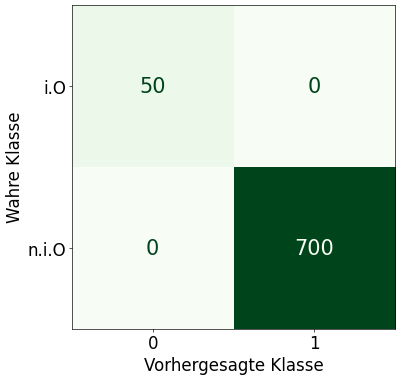

In [77]:
ch.plot_calc_cm(y_test0, y_pred0, class_name=["i.O", "n.i.O"], dpi=60)

In [78]:
def collect_results(clf, y_true, y_pred, algorithm, params, best_param):
    
    res = {"algorithm":algorithm, "params":params, "best_param":best_param,
           "rec_0":None, "pre_0":None, "f1_0":None, "rec_weighted":None, "pre_weighted":None, "f1_weighted":None, "acc":None}
    
    y_true0 = ch.swap_zero_one(y_true, 0)
    y_pred0 = ch.swap_zero_one(y_pred, 0)
    
    res["rec_0"] = recall_score(y_true0, y_pred0)
    res["pre_0"] = precision_score(y_true0, y_pred0)
    res["f1_0"] = f1_score(y_true0, y_pred0)
    res["rec_weighted"]= recall_score(y_true, y_pred, average='weighted')
    res["f1_weighted"]= f1_score(y_true, y_pred, average='weighted')
    res["pre_weighted"]= precision_score(y_true, y_pred, average='weighted')
    res["acc"] = accuracy_score(y_true, y_pred)
    
    for val in res.keys():
        if res[val]==None:
            print("somethong is wrong")
    
    return res

In [79]:
res = collect_results(best_clf, y_test, y_pred, algorithm="decisiontree", params=parameters, best_param=search.best_params_)
res

{'algorithm': 'decisiontree',
 'params': {'criterion': ['gini', 'entropy'],
  'min_samples_leaf': [1, 4, 8],
  'min_samples_split': [2, 4, 8],
  'max_depth': [20, 40, 80, 120, 200],
  'min_impurity_decrease': [0.0, 0.0001, 0.001]},
 'best_param': {'criterion': 'gini',
  'max_depth': 20,
  'min_impurity_decrease': 0.001,
  'min_samples_leaf': 4,
  'min_samples_split': 8},
 'rec_0': 1.0,
 'pre_0': 1.0,
 'f1_0': 1.0,
 'rec_weighted': 0.8708333333333333,
 'pre_weighted': 0.9083713690090754,
 'f1_weighted': 0.8882039560005145,
 'acc': 0.8173333333333334}

In [80]:
filename = "mlc_algorithm_adaption_hyperopt_results_v2.4.json"
key_algorithm = "dt"
hyperopt_result = res

In [81]:
if os.path.exists(f"results/{filename}") == False:
    with open(f"results/{filename}", "w") as f:
        json.dump({f"{key_algorithm}":hyperopt_result}, f)
        f.close()
else:
    with open(f"results/{filename}", "r") as f:
        data = json.load(f)
        data.update({f"{key_algorithm}":hyperopt_result})
        
    with open(f"results/{filename}", "w") as f:
        json.dump(data, f)
        f.close()